In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import glob
import os
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
!pip install umap-learn
import umap
# data_path = '/Users/ruchiraravishankar/Downloads/iam_dataset/'
data_path = '/content/drive/MyDrive/iam_dataset/'
save_path = "/content/drive/MyDrive/iam_dataset/saved_model/"

     |████████████████████████████████| 86 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 4.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=dfff93666f6e9f77372a78323b55f7d572db897df58a38c03173b34c72dd4a2f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=60e1df8758dcfd33e56c27df44511129c0dc93dec0f29b906782175cf457d8d0
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
# toggle the model for which softmax needs to be calibrated
model_node = 1 # options: 1,2,3,4,5,6,7, 23 (for model reuse)

# set transfer learned model type: either fc or conv
fc_conv = 'fc' # 'fc' or 'conv'

In [ ]:
labelled_data = np.load(data_path + 'labelled_data.npy')
print(labelled_data.shape)

(4901, 2)


In [ ]:
# if model_node is 1,2,3,4...
nodes_handled = [1,2,3,4,23]
if model_node in nodes_handled:
  labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

  print(labelled_data_0.shape)

  if model_node == 1 or model_node == 23:
    labelled_data_0 = labelled_data_0[:196]
    print("node 1, class 0 set")
  elif model_node == 2:
    labelled_data_0 = labelled_data_0[196:(196*2)]
    print("node 2, class 0 set")
  elif model_node == 3:
    labelled_data_0 = labelled_data_0[(196*2):(196*3)]
    print("node 3, class 0 set")
  elif model_node == 4:
    labelled_data_0 = labelled_data_0[:202]
    print("node 4, class 0 set")
  else:
    print("model_node not 1,2,3, or 4")

  print(labelled_data_0.shape)

  print(np.unique(labelled_data_0[:,1]))

  remove_000 = labelled_data[labelled_data[:,1]!='000']

  print(np.unique(remove_000[:,1]))
  print(np.unique(remove_000[:,1]).shape)

  y = [remove_000[remove_000[:,1]==k] for k in np.unique(remove_000[:,1])]
  print(len(y))

  labelled_data_1 = []

  if model_node == 1 or model_node == 23:
    for i in y:
      labelled_data_1.append(i[:4])
    print("node 1, class 1 set")
  elif model_node == 2:
    for i in y:
      labelled_data_1.append(i[5:9])
    print("node 2, class 1 set")  
  elif model_node == 3:
    for i in y:
      labelled_data_1.append(i[9:13])
    print("node 3, class 1 set")
  elif model_node == 4:
    for i in range(len(y)):
      if i == 0:
        labelled_data_1.append(y[i][:10])
      else:
        labelled_data_1.append(y[i][:4])
    print("node 4, class 1 set")
  else:
    print("model_node not 1,2,3, or 4")

  print(len(labelled_data_1))



  if model_node == 1 or model_node == 23 or model_node == 2 or model_node == 3:
    labelled_data_1 = np.array(labelled_data_1)
    print(labelled_data_1.shape)
    labelled_data_1=labelled_data_1.reshape(-1,2)
  if model_node == 4:
    labelled_data_1 = np.concatenate(labelled_data_1)

  print(labelled_data_1.shape)
  print(np.unique(labelled_data_1[:,1]))


  labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
  np.random.shuffle(labelled_data_new)
  print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

else:
  print("node not handled in this block")

(693, 2)
node 1, class 0 set
(196, 2)
['000']
['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)
49
node 1, class 1 set
49
(49, 4, 2)
(196, 2)
['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(392, 2)


In [ ]:
from random import uniform as rand

def randConstrained(n, M):
    splits = [0] + [rand(0, 1) for _ in range(0,n-1)] + [1]
    splits.sort()
    diffs = [x - splits[i - 1] for i, x in enumerate(splits)][1:]
    result = map(lambda x:x*M, diffs)
    return result

res = randConstrained(49,1.0)
res_list = list(res)
# print(sum(list(res)))
print(len(res_list))
print(sum(res_list))


# HERE - work with labelled_data for any sampling work
probs = randConstrained(49,1.0)
print(probs)
probs = list(probs)
# print(probs)
probs = np.array(probs)
print(probs[0])
# probs = np.insert(probs, 0, 0.5)
print(probs[1])
print(probs.shape)
def sampling(p, n):
  all_1_writers = np.unique(labelled_data[:,1])[np.unique(labelled_data[:,1])!= '000']
  ixs = np.arange(49)
  return np.array([all_1_writers[np.random.choice(ixs, p=p)] for i in range(n)])

49
1.0
0.022721037192758864
0.0343799641433713
(49,)


In [ ]:
if model_node == 5:

  label_array = sampling(probs, 200)

  labels, counts = np.unique(label_array, return_counts=True)


  print(labels, counts)
  print(labels.shape)
  print(sum(counts))

  all_1_data = labelled_data[labelled_data[:,1]!='000']

  # all_085 = all_1_data[all_1_data[:,1]=='085']
  # print(all_085.shape)

  data_list = []
  # data_list.append(all_085)
  for i in range(len(labels)):
    curr = all_1_data[all_1_data[:,1]==labels[i]][:counts[i]]
    data_list.append(curr)

  print(len(data_list))

  out = np.concatenate(data_list)
  print(out.shape)
  print("node 5, class 1 set")
  all_000 = labelled_data[labelled_data[:,1] == '000']
  np.random.shuffle(all_000)
  all_000 = all_000[:200]
  print(all_000.shape)
  print("node 5, class 0 set")
  labelled_data_new = np.concatenate([all_000, out])
  print(labelled_data_new.shape)

else:
  print("model node not handled in this block")


model node not handled in this block


In [ ]:
nodes = [6,7]
if model_node in nodes:
  if model_node == 6:
    label_array = sampling(probs, 400)
    print("node 6, class 1 set")
  elif model_node == 7:
    label_array = sampling(probs, 200)
    print("node 7, class 1 set")
  else:
    print("set model_node to either 6 or 7")

  labels, counts = np.unique(label_array, return_counts=True)

  print(labels, counts)
  print(labels.shape)
  print(sum(counts))

  all_1_data = labelled_data[labelled_data[:,1]!='000']

  # all_085 = all_1_data[all_1_data[:,1]=='085']
  # print(all_085.shape)

  data_list = []
  # data_list.append(all_085)
  for i in range(len(labels)):
    curr = all_1_data[all_1_data[:,1]==labels[i]][:counts[i]]
    data_list.append(curr)

  print(len(data_list))

  # lbl_data = np.array(data_list)
  out = np.concatenate(data_list)
  # lbl_data = lbl_data.flatten()
  # print(lbl_data)
  print(out.shape)
  all_000 = labelled_data[labelled_data[:,1] == '000']
  np.random.shuffle(all_000)

  if model_node == 6:
    all_000 = all_000[:200]
    print("node 6, class 0 set")
  elif model_node == 7:
    all_000 = all_000[:400]
    print("node 7, class 0 set")
  else:
    print("set model_node to either 6 or 7")
    
  print(all_000.shape)


  labelled_data_new = np.concatenate([all_000, out])
  print(labelled_data_new.shape)

else:
  print("model_node not handled in this block")

model_node not handled in this block


In [ ]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(175,) (130,) (87,) (175,) (130,) (87,)


In [ ]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [ ]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [ ]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
augsamps_test, auglbls_test = augment(X_test, y_test)
augsamps_val, auglbls_val = augment(X_val, y_val)

In [ ]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, augsamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)

aug_samps_val = reduce(operator.add, augsamps_val)
aug_lbls_val = reduce(operator.add, auglbls_val)

print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

print(len(aug_samps_val))
print(len(aug_lbls_val))

26878
26878
19438
19438
13666
13666


In [ ]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)
aug_samps_arr_val = np.array(aug_samps_val)
aug_lbls_arr_val = np.array(aug_lbls_val)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)
print(aug_samps_arr_val.shape)
print(aug_lbls_arr_val.shape)

(26878, 113, 113)
(26878,)
(19438, 113, 113)
(19438,)
(13666, 113, 113)
(13666,)


In [ ]:
X_train = aug_samps_arr
X_train = X_train.reshape(X_train.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_train = X_train.astype('float16')
X_train /= 255.0
y_train = aug_lbls_arr


X_test = aug_samps_arr_test
X_test = X_test.reshape(X_test.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_test = X_test.astype('float16')
X_test /= 255.0
y_test = aug_lbls_arr_test

X_val = aug_samps_arr_val
X_val = X_val.reshape(X_val.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_val = X_val.astype('float16')
X_val /= 255.0
y_val = aug_lbls_arr_val



In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(26878, 1, 113, 113)
(26878,)
(19438, 1, 113, 113)
(19438,)
(13666, 1, 113, 113)
(13666,)


In [ ]:
new = np.unique(y_train)
print(new)

y_train[y_train !='000'] = 1
new = np.unique(y_train)
print(new)

y_train[y_train=='000'] = 0
new = np.unique(y_train)
print(new)

print(y_train.shape)

y_train = y_train.astype('float16')

print(np.unique(y_train))

['000' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '274' '315' '332' '333' '334' '335' '336'
 '337' '338' '339' '340' '341' '342' '343' '344' '345' '346' '347' '348'
 '349' '384' '415' '551' '552' '567' '588' '634' '635' '670' '671']
['000' '1']
['0' '1']
(26878,)
[0. 1.]


In [ ]:
new = np.unique(y_test)
print(new)

y_test[y_test !='000'] = 1
new = np.unique(y_test)
print(new)

y_test[y_test=='000'] = 0
new = np.unique(y_test)
print(new)

print(y_test.shape)

y_test = y_test.astype('float16')

print(np.unique(y_test))

['000' '085' '150' '151' '152' '155' '202' '203' '204' '205' '207' '208'
 '247' '248' '273' '274' '315' '332' '333' '334' '335' '336' '337' '338'
 '339' '340' '341' '342' '343' '344' '345' '346' '347' '348' '349' '384'
 '415' '551' '552' '567' '588' '634' '635' '670' '671']
['000' '1']
['0' '1']
(19438,)
[0. 1.]


In [ ]:
new = np.unique(y_val)
print(new)

y_val[y_val !='000'] = 1
new = np.unique(y_val)
print(new)

y_val[y_val=='000'] = 0
new = np.unique(y_val)
print(new)

print(y_val.shape)

y_val = y_val.astype('float16')

print(np.unique(y_val))

['000' '085' '118' '151' '152' '153' '154' '202' '204' '205' '206' '207'
 '208' '209' '247' '248' '273' '332' '340' '342' '343' '345' '346' '347'
 '349' '384' '551' '552' '567' '634' '635' '670']
['000' '1']
['0' '1']
(13666,)
[0. 1.]


In [ ]:
torch.manual_seed(42)
CUDA = True
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()



# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
tensor_x_val = torch.Tensor(X_val).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_val = torch.Tensor(y_val).type(torch.cuda.FloatTensor).long()
# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

val_dataset = TensorDataset(tensor_x_val,tensor_y_val) # create your datset
val_dataloader = DataLoader(val_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).long().type(torch.cuda.FloatTensor).long()

# tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(y_test).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True) # create your dataloader

In [ ]:
tensor_x_train.shape

torch.Size([26878, 1, 113, 113])

In [ ]:
import torch
from torch import nn
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.fc1 = nn.Linear(4320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.relu(self.max_pool2d(self.conv1(x)))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv2(x))))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv3(x))))
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.conv_drop(x)
        x = self.fc2(x)
        return x

In [ ]:
model=Binary_Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

# import torch.optim.lr_scheduler.StepLR
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [ ]:
model_node_1 = 'model_3_convs.pt'

model_node_2_fc = 'model_tf_3_convs_retrain_last_fc_node2.pt'
model_node_2_conv = 'model_tf_3_convs_retrain_last_conv_node2.pt'

model_node_3_fc = 'model_tf_3_convs_retrain_last_fc_node3.pt'
model_node_3_conv = 'model_tf_3_convs_retrain_last_conv_node3.pt'

model_node_4_fc = 'model_3_convs_node_4_fc.pt'
model_node_4_conv = 'model_3_convs_node_4_conv.pt'

model_node_5_fc = 'model_3_convs_node5_fc.pt'
model_node_5_conv = 'model_3_convs_node5_conv.pt'

model_node_6_fc = '3convs_node6_fc.pt'
model_node_6_conv = '3convs_node6_conv.pt'

model_node_7_fc = '3convs_node7_fc.pt'
model_node_7_conv = '3convs_node7_conv.pt'

model_node2_node3 = 'modelreuse_node2convmodel_retrainedfc_on_node3.pt'

In [ ]:
if model_node == 1:
  model_path = model_node_1

elif model_node == 2:
  if fc_conv == 'fc':
    model_path = model_node_2_fc
  elif fc_conv == 'conv':
    model_path = model_node_2_conv
  else:
    print("set fc_conv to fc or conv")


elif model_node == 3:
  if fc_conv == 'fc':
    model_path = model_node_3_fc
  elif fc_conv == 'conv':
    model_path = model_node_3_conv
  else:
    print("set fc_conv to fc or conv")

elif model_node == 4:
  if fc_conv == 'fc':
    model_path = model_node_4_fc
  elif fc_conv == 'conv':
    model_path = model_node_4_conv
  else:
    print("set fc_conv to fc or conv")

elif model_node == 5:
  if fc_conv == 'fc':
    model_path = model_node_5_fc
  elif fc_conv == 'conv':
    model_path = model_node_5_conv
  else:
    print("set fc_conv to fc or conv")

elif model_node == 6:
  if fc_conv == 'fc':
    model_path = model_node_6_fc
  elif fc_conv == 'conv':
    model_path = model_node_6_conv
  else:
    print("set fc_conv to fc or conv")

elif model_node == 7:
  if fc_conv == 'fc':
    model_path = model_node_7_fc
  elif fc_conv == 'conv':
    model_path = model_node_7_conv
  else:
    print("set fc_conv to fc or conv")

elif model_node == 23:
  model_path = model_node2_node3

else:
  print("set model_node variable at the top of the file")

In [ ]:
# if os.path.exists(save_path+'/model_3_convs_node6_conv.pt'):
try:
    print('Loading checkpoint: %s' % save_path + model_path)
    path = torch.load(save_path + model_path)
    # epoch = path['epoch']
    model.load_state_dict(path['model'])
    optimizer.load_state_dict(path['optimizer'])
except Exception as e:
  print("nothing happened")
  print(e)

Loading checkpoint: /content/drive/MyDrive/iam_dataset/saved_model/model_3_convs.pt


In [ ]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(1214, 16, 2) (1214, 16)


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Text(0.5, 1.0, 'PCA and UMAP')

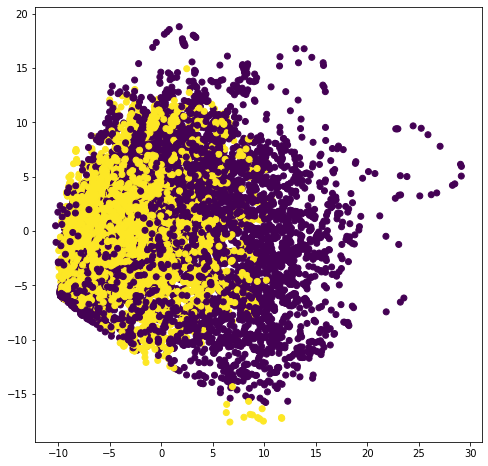

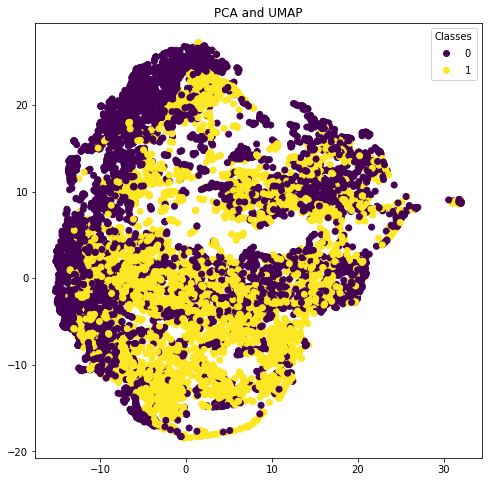

In [ ]:
import matplotlib.pyplot as plt

# pca on the X_test, i.e., the image dataset, this is what the umap is fit and transformed on
x_pca = PCA(n_components=50,random_state=42).fit_transform(X_test[:10000].reshape(10000,113*113))
plt.figure(figsize=(8,8))
categories = ['0', '1']
scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=y_test[:10000], cmap='viridis')


reducer = umap.UMAP(n_components=2, random_state=42, spread=5, min_dist=0.001) 
embedding = reducer.fit_transform(x_pca)
embedding.shape

plt.figure(figsize=(8,8))
# the cmap is the y_test, i.e., to colour the dataset based on the classes
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=y_test[:10000], cmap='viridis')
plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
plt.title('PCA and UMAP')

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Text(0.5, 1.0, 'PCA and UMAP')

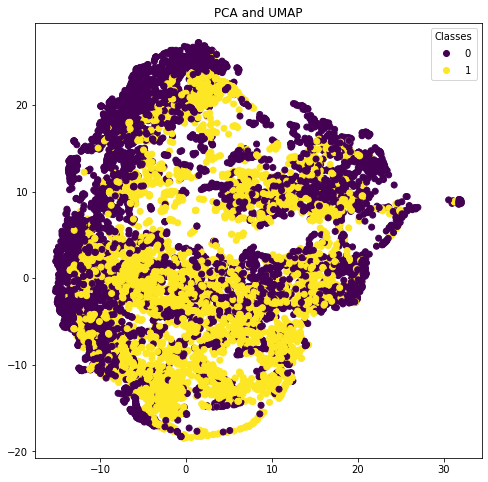

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42, spread=5, min_dist=0.001) 
embedding = reducer.fit_transform(x_pca)
embedding.shape

plt.figure(figsize=(8,8))
# the cmap is the prediction, i.e., to colour the dataset based on the classes predicted
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=prediction.reshape(-1)[:10000], cmap='viridis')
plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
plt.title('PCA and UMAP')